In [1]:
!pip install timm

In [35]:
import torchvision
import torch
from torch import nn
import torch.nn.functional as F
from timm.models.layers import trunc_normal_

D_base = 96
M = 7
h = 3
B = 16
#d = D_base // h
num_classes = 10

class WMSA(nn.Module):
  def __init__(self, D, shift=False):
    super(WMSA, self).__init__()
    self.D = D
    self.shift = shift

    self.QKV_embed = nn.Linear(self.D, 3*self.D)
    self.proj = nn.Linear(self.D, self.D)
    self.relative_position_bias_table = nn.Parameter(torch.zeros((2*M-1) * (2*M-1), h)) # 2*M-1

    _x = torch.arange(M).cuda()
    _y = torch.arange(M).cuda()
    _grid_x, _grid_y = torch.meshgrid(_x, _y)
    meshgrid = torch.stack((_grid_x, _grid_y), dim=2).flatten(0, 1) # M M 2 -> M*M, 2
    #print(meshgrid.shape)
    self.relative_pos = meshgrid[None, :, :] - meshgrid[:, None, :] 
    #relative pos. #M*M, M*M, 2
    self.relative_pos += M-1 # to start from 0

    trunc_normal_(self.relative_position_bias_table, std=.02)

  def forward(self, X):
    #B nh nw D
    nh, nw = X.size(1), X.size(2)
    D = self.D
    d = D // h
    #print(self.relative_pos.shape)
    pos_enc = self.relative_position_bias_table[self.relative_pos[:, :, 0]*(2*M-1)+self.relative_pos[:, :, 1]]
     # M*M, M*M, h (hard indexing)
    #print(pos_enc.shape)
    pos_enc = pos_enc.permute(2, 0, 1)
    #.reshape(h, M*M, M*M)
    

    if self.shift:
      X = torch.roll(X, shifts=(-M//2, -M//2), dims=(1, 2))
      
      #make mask(rolled)

      #mask = torch.zeros((nh//M) * (nw//M), M,M, M,M).cuda()
      mask_image = torch.zeros(nh, nw).cuda()
      h_slices = (slice(0, -M),
                  slice(-M, -M//2),
                  slice(-M//2, None))
      w_slices = (slice(0, -M),
                  slice(-M, -M//2),
                  slice(-M//2, None))
      
      cnt = 0
      for i in h_slices:
        for j in w_slices:
          mask_image[i, j] = cnt
          cnt += 1

      mask_image = mask_image.reshape(nh//M, M, nw//M, M).permute(0, 2, 1, 3) # nh//M, nw//M, M, M
      attn_mask = mask_image[:, :, :, :, None, None] - mask_image[:, :, None, None, :, :] #nh//M, nw//M, M,M, M,M
      attn_mask = attn_mask.masked_fill(mask != 0, float(-100.)).masked_fill(mask == 0, float(0.))
      attn_mask = attn_mask.flatten(4, 5).flatten(2, 3) #nh//M, nw//M, M*M, M*M
      attn_mask = attn_mask[None, :, :, None, :, :] # B nh nw h M*M M*M
    else:
      attn_mask = torch.zeros(1, nh//M, nw//M, h, M*M, M*M).cuda()
    
    QKV = self.QKV_embed(X).reshape(-1, nh//M, M, nw//M, M, 3, h, d).permute(5, 0, 1, 3, 6, 2, 4, 7).flatten(5, 6) # B nh M nw M 3D -> B nh M nw M 3 h D -> 3 B nh nw h M M d -> 3 B nh nw h M*M d
    Q, K, V = QKV[0], QKV[1], QKV[2]

    attention = torch.softmax((Q @ K.transpose(-1, -2) * d**(-1/2))+pos_enc+attn_mask, dim=-1) # B nh nw h M*M M*M
    X = (attention @ V) # B nh nw h M*M d
    X = X.reshape(-1, nh//M, nw//M, h, M, M, d).permute(0, 1, 4, 2, 5, 3, 6).reshape(-1, nh, nw, D)  # B nh M nw M h d -> B nh mw h d
    X = self.proj(X)
    return X # B nh nw D

  # def swin_forward(self, X):
  #   # B nh nw D
  #   X = torch.roll(X, shifts=(-M//2, -M//2), dims=(1, 2))
    
  #   #make mask(rolled)

  #   mask = torch.zeros((nh//M) * (nw//M), M,M, M,M)
  #   mask_image = torch.zeros(nh, nw)
  #   h_slices = (slice(0, -M),
  #               slice(-M, -M//2),
  #               slice(-M//2, None))
  #   w_slices = (slice(0, -M),
  #               slice(-M, -M//2),
  #               slice(-M//2, None))
    
  #   cnt = 0
  #   for i in h_slices:
  #     for j in w_slices:
  #       mask_image[i, j] = cnt
  #       cnt += 1

  #   mask_image = mask_image.reshape(nh//M, M, nw//M, M).permute(0, 2, 1, 3) # nh//M, nw//M, M, M
  #   attn_mask = mask_image[:, :, :, :, None, None] - mask_image[:, :, None, None, :, :] #nh//M, nw//M, M,M, M,M
  #   attn_mask = attn_mask.masked_fill(mask != 0, float(-100.)).masked_fill(mask == 0, float(0.))
  #   attn_mask = attn_mask.flatten(4, 2).flatten(2, 2) #nh//M, nw//M, M*M, M*M
  #   attn_mask = attn_mask[None, :, :, None, :, :] # B nh nw h M*M M*M
    
        

  #   pos_enc = relative_position_bias_table[relative_pos[:, :, :, :, 0], relative_pos[:, :, :, :, 1]] # M,M, M,M (hard indexing)
  #   print(pos_enc.shape)
  #   QKV = self.QKV_embed(X).reshape(B, nh//M, M, nw//M, M, 3, h, d).permute(5, 0, 1, 3, 6, 2, 4, 7).flatten(5, 2) # B nh M nw M 3D -> B nh M nw M 3 h D -> 3 B nh nw h M M d -> 3 B nh nw h M*M d
  #   Q, K, V = QKV[0], QKV[1], QKV[2]


  #   attention = torch.softmax((Q @ K.transpose(-1, -2) * d**(-1/2))+attn_mask, dim=-1) # B nh nw h M*M M*M
  #   X = (attention @ V) # B nh nw h M*M d
  #   X = X.reshape(B, nh//M, nw//M, h, M, M, d).permute(0, 1, 4, 2, 5, 3, 6).reshape(B, nh, nw, D)  # B nh M nw M h d -> B nh mw h d
  #   X = self.proj(X)
  #   return X # B nh nw D


class MLP(nn.Module):
  def __init__(self, D):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(D, 4*D)
    self.fc2 = nn.Linear(4*D, D)
  
  def forward(self, X):
    #X : B N D
    X = F.gelu(self.fc1(X))
    X = self.fc2(X)
    return X

class Block(nn.Module):
  def __init__(self, D, shift=False, drop_path_rate=0.2):
    super(Block, self).__init__()
    self.drop_path_rate = drop_path_rate
    self.norm1 = nn.LayerNorm(D, eps=1e-6)
    self.MSA = WMSA(D)
    self.norm2 = nn.LayerNorm(D, eps=1e-6)
    self.MLP = MLP(D)
  def drop_path(self, x, drop_path_rate):
    if drop_path_rate == 0.:
      return x

    rand = torch.rand((x.shape[0],) + (1,)*(x.ndim-1)).cuda()
    rand = torch.floor((1-drop_path_rate) + rand)
    return x / (1-drop_path_rate) * rand
  

  def forward(self, X):
    X = X + self.drop_path(self.MSA(self.norm1(X)), self.drop_path_rate)
    X = X + self.drop_path(self.MLP(self.norm2(X)), self.drop_path_rate)
    return X

class Merge(nn.Module):
  def __init__(self, D):
    super(Merge, self).__init__()
    self.D = D
    self.norm = nn.LayerNorm(4*D)
    self.reduction = nn.Linear(4*D, 2*D)

  def forward(self, X):
    #B nh nw D
    #returns B nh//2 nw//2 D*2
    B, nh, nw = X.size(0), X.size(1), X.size(2)
    D = self.D
    #print(self.D, X.size(3))
    X = X.reshape(B, nh//2, 2, nw//2, 2, D).permute(0, 1, 3, 2, 4, 5)
    X = X.reshape(B, nh//2, nw//2, 4*D)
    X = self.norm(X)
    X = self.reduction(X)
    return X

class Swin(nn.Module):
  def __init__(self):
    super(Swin, self).__init__()

    self.drop_depth = 0.1
    drop_depth_p = torch.linspace(0, self.drop_depth, 10)

    self.patch_embed = nn.Conv2d(3, D_base, kernel_size=4, stride=4)
    self.patch_norm = nn.LayerNorm(D_base)

    #self.layers = nn.ModuleList()

    self.stage1 = nn.Sequential(*[
        Block(D_base, shift=s, drop_path_rate=drop_depth_p[i])
      for i in range(2)
      for s in (False, True)])
    self.merge1 = Merge(D_base)

    self.stage2 = nn.Sequential(*[
        Block(2*D_base, shift=s, drop_path_rate=drop_depth_p[i])
      for i in range(2)
      for s in (False, True)])
    self.merge2 = Merge(2*D_base)
    
    self.stage3 = nn.Sequential(*[
        Block(4*D_base, shift=s, drop_path_rate=drop_depth_p[i])
      for i in range(6)
      for s in (False, True)])
    self.merge3 = Merge(4*D_base)
    
    self.stage4 = nn.Sequential(*[
        Block(8*D_base, shift=s, drop_path_rate=drop_depth_p[i])
      for i in range(2)
      for s in (False, True)])
    

    self.norm = nn.LayerNorm(8*D_base)

    #head
    self.avgpool = nn.AdaptiveAvgPool1d(1)
    self.head = nn.Linear(8*D_base, num_classes)
    #self.cls_head = nn.Linear(D, num_classes)
    #self.dist_head = nn.Linear(D, num_classes)
    self.init_weights()


    resize_enc = False
    if resize_enc:
      pass

  def init_weights(self):
    ### need to init parameters in attention 
    #trunc_normal_(self.pos_enc, std=.02)
    #trunc_normal_(self.cls_patch, std=.02)
    self.apply(self.init_weights_func)
  
  def init_weights_func(self, m):
    
    if isinstance(m, nn.Linear):
      trunc_normal_(m.weight, std=.02)
      torch.nn.init.zeros_(m.bias)
      
    # elif isinstance(m, nn.Conv2d):
    #   return
      
    elif isinstance(m, nn.LayerNorm):
      torch.nn.init.ones_(m.weight)
      torch.nn.init.zeros_(m.bias)


  def forward(self, X):
    #So Low Efficiency... Maybe I should print/lookahead official code 
    # X: B, 3, H, W (224 * 224)
    B, hh, ww = X.size(0), X.size(2), X.size(3)
    #B 3 H W 
    #print(type(hh//4), type(ww//4))
    #H = X.reshape(B, 3, hh//4, 4, ww//4, 4) # B 3 nh 4 nw 4 -> B 48 nh nw
    H = self.patch_embed(X) # B D hh//4 ww//4
    H = H.permute(0, 2, 3, 1) # B nh nw 48
    H = self.patch_norm(H)

    H = self.stage1(H)
    H = self.merge1(H)
    H = self.stage2(H)
    H = self.merge2(H)
    H = self.stage3(H)
    H = self.merge3(H)
    H = self.stage4(H)
    #H = self.merge4(H)
    
    H = self.norm(H)
    H = H.view(B, -1, 8*D_base) # B nh*nw 8*D
    H = self.avgpool(H.transpose(1, 2)).squeeze(2)
    H = self.head(H)
    return H
  
  # def resize_pos_enc(self, pos_enc):
  #   #14*14 -> 24*24
  #   pos_enc_token = pos_enc[:, :2, :]
  #   pos_enc_grid = pos_enc[:, 2:, :]
  #   n = int(pos_enc_grid.size(1) ** 0.5)
  #   n_ = 24
  #   D = pos_enc_grid.size(2)
  #   _pos_enc_grid = pos_enc_grid.reshape(-1, n, n, D).permute(0, 3, 1, 2)
  #   _pos_enc_grid = F.interpolate(_pos_enc_grid, size=(n_, n_), mode='bicubic', align_corners=False)
  #   pos_enc_grid = _pos_enc_grid.permute(0, 2, 3, 1).flatten(1, 2)
  #   pos_enc = torch.cat((pos_enc_token, pos_enc_grid), dim=1)
  #   print(pos_enc.shape)
  #   return nn.Parameter(pos_enc)
    
model = Swin()



In [3]:
[s for i in range(2) for s in (False, True)]

[False, True, False, True]

In [4]:
x = torch.zeros(8, 3, 224, 224)
model(x).shape

RuntimeError: ignored

In [ ]:
a = torch.arange(64).reshape(8, 8)
a = a.reshape(4, 2, 4, 2).permute(0, 2, 1, 3)
a

In [5]:
from torch.utils.data import Sampler
from torchvision.transforms import RandomResizedCrop
import torchvision
from torchvision.transforms import RandomHorizontalFlip
from torchvision.transforms import ColorJitter

In [6]:
rrc = RandomResizedCrop((224, 224), scale=(1, 1), ratio=(1, 1), interpolation=torchvision.transforms.InterpolationMode.BILINEAR)
rhf = RandomHorizontalFlip(p=0.5)
cj = ColorJitter(brightness=0.3, contrast=0.3, saturation=0, hue=0) 
tt = torchvision.transforms.ToTensor()
n = torchvision.transforms.Normalize(mean=0.5, std=0.5)
re = torchvision.transforms.RandomErasing(p=0.5, scale=(0.02, 0.3), ratio=(0.3, 3.3), value=0) 

In [7]:
tc = torchvision.transforms.Compose([
  rrc,
  rhf,
  cj,
  tt,
  n,
  re
])

In [8]:
train_ds = torchvision.datasets.CIFAR10(root='.', train=True, download=True, transform=tc)
nb_classes = 10

Files already downloaded and verified


In [9]:
def build_transform(is_train, config):
    resize_im = config.DATA.IMG_SIZE > 32
    if is_train:
        # this should always dispatch to transforms_imagenet_train
        transform = create_transform(
            input_size=config.DATA.IMG_SIZE,
            is_training=True,
            color_jitter=config.AUG.COLOR_JITTER if config.AUG.COLOR_JITTER > 0 else None,
            auto_augment=config.AUG.AUTO_AUGMENT if config.AUG.AUTO_AUGMENT != 'none' else None,
            re_prob=config.AUG.REPROB,
            re_mode=config.AUG.REMODE,
            re_count=config.AUG.RECOUNT,
            interpolation=config.DATA.INTERPOLATION,
        )
        if not resize_im:
            # replace RandomResizedCropAndInterpolation with
            # RandomCrop
            transform.transforms[0] = transforms.RandomCrop(config.DATA.IMG_SIZE, padding=4)
        return transform

    t = []
    if resize_im:
        if config.TEST.CROP:
            size = int((256 / 224) * config.DATA.IMG_SIZE)
            t.append(
                transforms.Resize(size, interpolation=_pil_interp(config.DATA.INTERPOLATION)),
                # to maintain same ratio w.r.t. 224 images
            )
            t.append(transforms.CenterCrop(config.DATA.IMG_SIZE))
        else:
            t.append(
                transforms.Resize((config.DATA.IMG_SIZE, config.DATA.IMG_SIZE),
                                  interpolation=_pil_interp(config.DATA.INTERPOLATION))
            )

    t.append(transforms.ToTensor())
    t.append(transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD))
    return transforms.Compose(t)


In [54]:
# def create_transform(
#         input_size,
#         is_training=False,
#         use_prefetcher=False,
#         no_aug=False,
#         scale=None,
#         ratio=None,
#         hflip=0.5,
#         vflip=0.,
#         color_jitter=0.4,
#         auto_augment=None,
#         interpolation='bilinear',
#         mean=IMAGENET_DEFAULT_MEAN,
#         std=IMAGENET_DEFAULT_STD,
#         re_prob=0.,
#         re_mode='const',
#         re_count=1,
#         re_num_splits=0,
#         crop_pct=None,
#         tf_preprocessing=False,
#         separate=False):
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.data import create_transform
tfm = create_transform(
    input_size=(224, 224),
    is_training=False,
    use_prefetcher=False,
    no_aug=False,
    scale=None,
    ratio=None,
    hflip=0.5,
    vflip=0.,
    color_jitter=0.4,
    auto_augment=None,
    interpolation='bilinear',
    mean=IMAGENET_DEFAULT_MEAN,
    std=IMAGENET_DEFAULT_STD,
    re_prob=0.25, #random erase
    re_mode='pixel',
    re_count=1,
)

from timm.data import Mixup
mixup_fn = None

mixup_fn = Mixup(
   mixup_alpha=0.8,
   cutmix_alpha=1.,
   cutmix_minmax=None,
   prob=1.0,
   switch_prob=0.5,
   mode='batch',
   correct_lam=True,
   label_smoothing=0.1,
   num_classes=num_classes 
)

# class Mixup:
#     """ Mixup/Cutmix that applies different params to each element or whole batch
#     Args:
#         mixup_alpha (float): mixup alpha value, mixup is active if > 0.
#         cutmix_alpha (float): cutmix alpha value, cutmix is active if > 0.
#         cutmix_minmax (List[float]): cutmix min/max image ratio, cutmix is active and uses this vs alpha if not None.
#         prob (float): probability of applying mixup or cutmix per batch or element
#         switch_prob (float): probability of switching to cutmix instead of mixup when both are active
#         mode (str): how to apply mixup/cutmix params (per 'batch', 'pair' (pair of elements), 'elem' (element)
#         correct_lam (bool): apply lambda correction when cutmix bbox clipped by image borders
#         label_smoothing (float): apply label smoothing to the mixed target tensor
#         num_classes (int): number of classes for target
#     """
#     def __init__(self, mixup_alpha=1., cutmix_alpha=0., cutmix_minmax=None, prob=1.0, switch_prob=0.5,
#                  mode='batch', correct_lam=True, label_smoothing=0.1, num_classes=1000):
#         self.mixup_alpha = mixup_alpha




/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [11]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)

In [21]:
def get_loss(H_cls, Y):
  loss = F.cross_entropy(H_cls, Y)
  return loss

from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
def get_soft_loss(H_cls, Y):
  loss = SoftTargetCrossEntropy()(H_cls, Y)
  return loss

In [13]:
import numpy as np

In [42]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Swin().to(dev)
opt = torch.optim.AdamW(model.parameters(), 0.000001, weight_decay = 0.05)

train_ds = torchvision.datasets.CIFAR10(root='.', train=True, download=True, transform=tfm)
train_dl = DataLoader(train_ds, batch_size=8, shuffle=False)

from timm.scheduler.cosine_lr import CosineLRScheduler
scheduler = CosineLRScheduler(
    optimizer = opt,
    t_initial=300*len(train_dl), # epochs within first cycle
    t_mul=1., # determines number of iterations in i-th cycle
    lr_min=5e-6,
    decay_rate=0.1,
    warmup_t=20,
    warmup_lr_init=5e-7,
    warmup_prefix=False,
    cycle_limit=1,
    t_in_epochs=False,
    #noise_range_t=None,
    #noise_pct=0.67,
    #noise_std=1.0,
    #noise_seed=42,
    #initialize=True
)
for epoch_idx in range(300):
  for (batch_idx, (X, Y)) in enumerate(train_dl):
    X, Y = X.to(dev), Y.to(dev)
    X, Y = mixup_fn(X, Y)

    Y_pred_cls = model(X)
    loss = get_soft_loss(Y_pred_cls, Y)

    opt.zero_grad()
    
    loss.backward()
    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    opt.step()
    print(loss.item())
    break
  scheduler.step_update(epoch_idx * len(train_dl) + batch_idx)
  

Files already downloaded and verified
2.4963483810424805
2.4500837326049805
2.4398393630981445
2.36940860748291
2.36515474319458
2.2482423782348633
2.2071664333343506
2.1544110774993896
2.1127123832702637
2.039813995361328
2.048001289367676
2.0046935081481934
1.917588710784912
1.8873451948165894
1.8494186401367188
1.805419683456421
1.8396360874176025
1.7620763778686523
1.6706595420837402
1.6862802505493164
1.7407647371292114
1.6385149955749512
1.5304442644119263
1.4972612857818604
1.5169119834899902
1.4398831129074097
1.5255954265594482
1.5637139081954956
1.4856319427490234
1.4562625885009766
1.4760105609893799
1.305509090423584
1.2931108474731445
1.2443618774414062
1.2211041450500488
1.2460193634033203
1.3752801418304443
1.3622400760650635
1.3492776155471802
1.3102867603302002
1.3543050289154053
1.379155158996582
1.0974538326263428
1.22737455368042
1.2921688556671143
1.0883736610412598
1.0218541622161865
1.2981030941009521
1.1152456998825073
1.2016398906707764
1.224739670753479
1.0473

KeyboardInterrupt: ignored

In [17]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 2            |        cudaMalloc retries: 2         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  366535 KB |   14014 MB |   22452 MB |   22094 MB |
|       from large pool |  347783 KB |   13977 MB |   22413 MB |   22074 MB |
|       from small pool |   18752 KB |      37 MB |      38 MB |      20 MB |
|---------------------------------------------------------------------------|
| Active memory         |  366535 KB |   14014 MB |   22452 MB |   22094 MB |
|       from large pool |  347783 KB |   13977 MB |   22413 MB |

In [ ]:
print(scheduler.state_dict())

In [44]:
#eval
def acc1(Y_pred, Y):
  print(Y_pred.argmax(dim=-1), Y)
  return (Y_pred.argmax(dim=-1) == Y).sum()

def acc5(Y_pred, Y):
  _, Y_pred_topk = torch.topk(Y_pred, 5, dim=-1)
  return (Y_pred_topk == Y[:, None].expand_as(Y_pred_topk)).sum()



for (batch_idx, (X, Y)) in enumerate(train_dl):
  with torch.no_grad():
    X, Y = X.cuda(), Y.cuda()
    Y_pred = model(X)
    loss = get_loss(Y_pred, Y)

    print(loss.item())
    print(acc1(Y_pred, Y) / Y.size(0))
    print(acc5(Y_pred, Y) / Y.size(0))
    break

0.37577173113822937
tensor([6, 9, 9, 4, 1, 1, 2, 7], device='cuda:0') tensor([6, 9, 9, 4, 1, 1, 2, 7], device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')


In [67]:
rs = torchvision.transforms.Resize((224, 224))
tt = torchvision.transforms.ToTensor()
n = torchvision.transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD)
tc_val = torchvision.transforms.Compose([
  rs,
  tt,
  n,
])
test_ds = torchvision.datasets.CIFAR10('.', train=False, download=True, transform=tc_val)
test_dl = DataLoader(test_ds, batch_size=128, shuffle=True)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9 truck
tensor([9], device='cuda:0')
tensor([[9, 1, 2, 4, 7]], device='cuda:0')
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


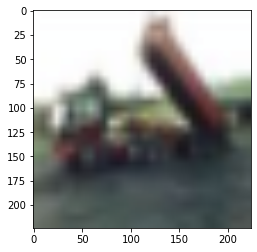

In [72]:
img = train_ds[2][0]
y = train_ds[2][1]
#rc = torchvision.transforms.Resize()

#print(tfm(img))
import matplotlib.pyplot as plt
plt.imshow(img.permute(1, 2, 0).numpy()*IMAGENET_DEFAULT_STD + IMAGENET_DEFAULT_MEAN)

with torch.no_grad():
  y_pred = model(img[None, :, :, :].cuda())
  print(y, train_ds.classes[y])
  print(y_pred.argmax(dim=-1))
  print(torch.topk(y_pred, 5, dim=-1)[1])
  print(train_ds.classes)


In [59]:
train_ds = torchvision.datasets.CIFAR10(root='.', train=True, download=True, transform=tfm)

Files already downloaded and verified


In [68]:
train_ds = torchvision.datasets.CIFAR10(root='.', train=True, download=True, transform=tc_val)

Files already downloaded and verified
